In [32]:
%reset -f
import time
time_start = time.time()

import numpy as np
import matplotlib.pyplot as plt
from matplotlib import cm
import pyroomacoustics as pra
import librosa
import librosa.display
import IPython.display as ipd
import soundfile as sf

## RIR parameter

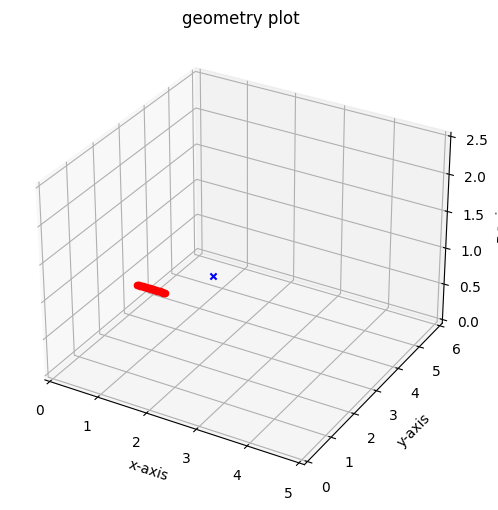

In [33]:
SorNum = 1
MicNum = 30
c = 343
fs = 16000
Ts = 1/fs

# UCA #
# radius_UCA = 0.5
# angle_step = 360/MicNum
# MicCenter = [1, 3, 1]    # 麥克風陣列中心點
# MicPos = np.zeros((3, MicNum))
# for mic_num in range(MicNum) :
#     MicPos[:, mic_num] = np.array([MicCenter[0] + radius_UCA*np.cos(angle_step*mic_num*np.pi/180), MicCenter[1] + radius_UCA*np.sin(angle_step*mic_num*np.pi/180), MicCenter[2]])

# ULA #
MicStart = [1, 1.5, 1]
spacing = 0.02
MicPos = np.zeros((3, MicNum))
for mic_num in range(MicNum) :
    MicPos[:, mic_num] = np.array([MicStart[0] + mic_num*spacing, MicStart[1], MicStart[2]])

SorPos = [2, 2.6, 1]
room_dim = [5, 6, 2.5]
reverberation_time = 0.2    # T60
points_rir = 4096
dim = 3
orientation = [0, 90]    # [水平 垂直]

# 畫空間圖 #
fig1 = plt.figure(figsize=(6, 6))
ax1 = fig1.add_subplot(projection='3d')
for mic_num in range(MicNum) :
    ax1.scatter(MicPos[0, mic_num], MicPos[1, mic_num], MicPos[2, mic_num], c='r', marker='o')

ax1.scatter(SorPos[0], SorPos[1], SorPos[2], c='b', marker='x')
ax1.set_xlim((0, room_dim[0]))
ax1.set_ylim((0, room_dim[1]))
ax1.set_zlim((0, room_dim[2]))
ax1.set_title('geometry plot')
ax1.set_xlabel('x-axis')
ax1.set_ylabel('y-axis')
ax1.set_zlabel('z-axis')
plt.show()

## generate ground-truth RIR (h)

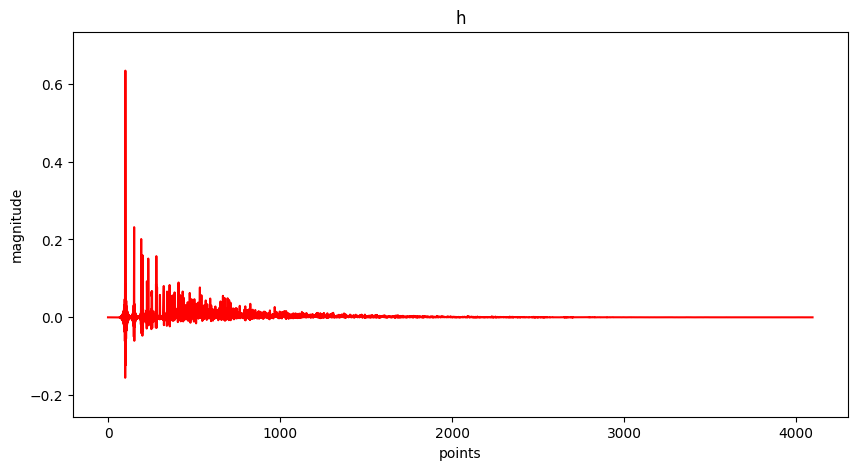

In [34]:
# 產生 RIR #
e_absorption, max_order = pra.inverse_sabine(reverberation_time, room_dim)
room = pra.ShoeBox(room_dim, fs=fs, materials=pra.Material(e_absorption), max_order=max_order)

from pyroomacoustics.directivities import (
    DirectivityPattern,
    DirectionVector,
    CardioidFamily
)

dir_mic = CardioidFamily(
    orientation=DirectionVector(azimuth=orientation[0], colatitude=orientation[1], degrees=True),
    pattern_enum=DirectivityPattern.OMNI
)

room.add_source(position=SorPos)
room.add_microphone(loc=MicPos, directivity=dir_mic)
room.compute_rir()
h = np.zeros((MicNum, points_rir))
for mic_num in range(MicNum) :
    h[mic_num, :] = room.rir[mic_num][0][0:points_rir]     

# 畫 ground-truth RIR time plot #
look_mic = 14
fig2 = plt.figure(figsize=(10, 5))
ax2 = fig2.add_subplot()
ax2.plot(h[look_mic, :], 'r')
h_yaxis_underlimit = np.min(h[look_mic]) - 0.1
h_yaxis_upperlimit = np.max(h[look_mic]) + 0.1
ax2.set_ylim((h_yaxis_underlimit, h_yaxis_upperlimit))
ax2.set_title('h')
ax2.set_xlabel('points')
ax2.set_ylabel('magnitude')
plt.show()

## compute ground-truth CTF (H)

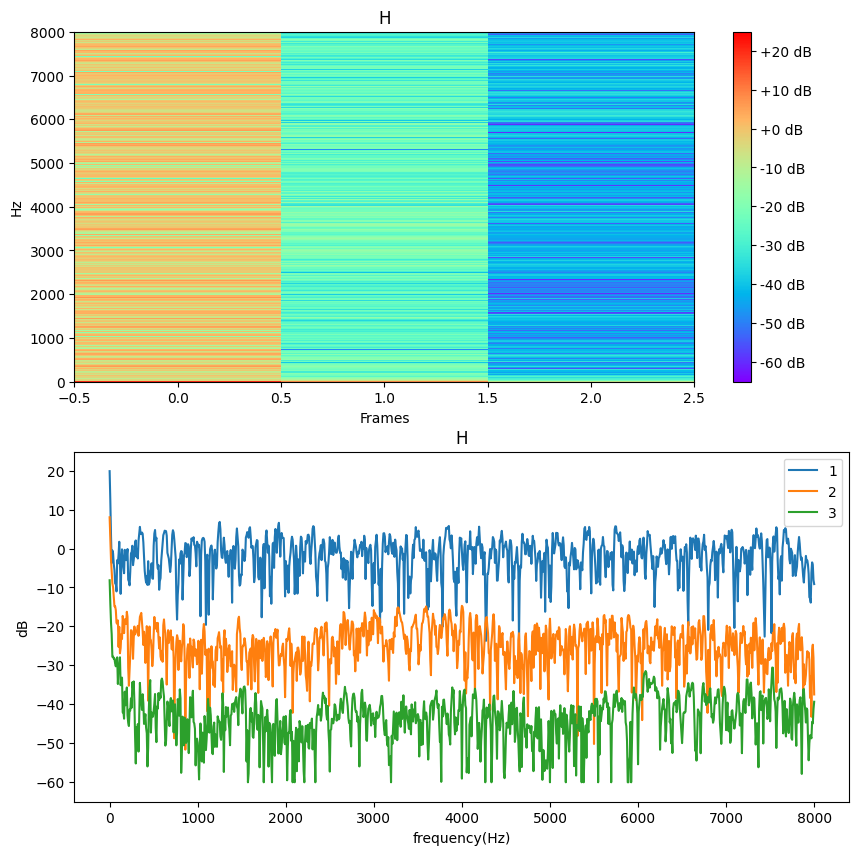

In [35]:
NWIN = 2048
NFFT = 2048
center = False    # True or False
hopsize = int(NWIN/2)

# RIR 轉頻域 #
H = librosa.stft(h, n_fft=NFFT, hop_length=hopsize, win_length=NWIN, window='boxcar', center=center)
frequency = H.shape[1]
freqs_vector = (fs/2)*np.linspace(0, 1, frequency)
L  = H.shape[2]

# 畫 ground-truth RIR frequency plot #
fig3 = plt.figure(figsize=(10, 10))
ax3_1 = fig3.add_subplot(2, 1, 1)
H_caxis_underlimit = np.min(librosa.amplitude_to_db(np.abs(H[look_mic]))) - 5
H_caxis_upperlimit = np.max(librosa.amplitude_to_db(np.abs(H[look_mic]))) + 5
img = librosa.display.specshow(librosa.amplitude_to_db(np.abs(H[look_mic])), sr=fs,  hop_length=hopsize, y_axis='linear', x_axis='frames',
                                ax=ax3_1, cmap=cm.rainbow, vmin=H_caxis_underlimit, vmax=H_caxis_upperlimit)
ax3_1.set_title('H')
fig3.colorbar(img, ax=ax3_1, format="%+2.0f dB")

ax3_2 = fig3.add_subplot(2, 1, 2)
ax3_2.plot(freqs_vector, librosa.amplitude_to_db(np.abs(H[look_mic])))
ax3_2.set_ylim((H_caxis_underlimit, H_caxis_upperlimit))
ax3_2.set_title('H')
ax3_2.set_xlabel('frequency(Hz)')
ax3_2.set_ylabel('dB')
if H[look_mic].shape[1] < 10 :
    ax3_2.legend([str(i+1) for i in range(H[look_mic].shape[1])])
plt.show()

## reconstruct RIR from H (h_recon)

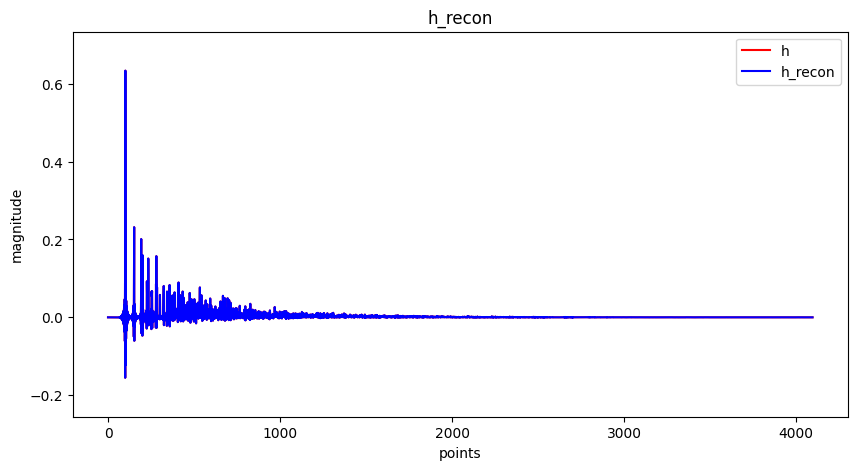

In [36]:
# H 轉回時域 #
h_recon = librosa.istft(H, hop_length=hopsize, win_length=NWIN, n_fft=NFFT, window='boxcar', center=center)

# 畫 reconstruct RIR time plot #
fig4 = plt.figure(figsize=(10, 5))
ax4 = fig4.add_subplot()
ax4.plot(h[look_mic, :], 'r')
ax4.plot(h_recon[look_mic, :], 'b')
ax4.set_ylim((h_yaxis_underlimit, h_yaxis_upperlimit))
ax4.set_title('h_recon')
ax4.set_xlabel('points')
ax4.set_ylabel('magnitude')
ax4.legend(['h', 'h_recon'])
plt.show()

## 讀音檔 or 產生 white noise source (source)

In [37]:
Second = 20
SorLen =  Second*fs

# load source #
source, fs= librosa.load('245.wav', sr=fs, mono=True, offset=0.0, duration=Second, dtype=np.float32)    # speech source
# source = np.random.normal(0, 1, size=SorLen)                                                            # white noise source

## compute source signal for frequency (S)

In [38]:
# source 轉頻域 #
S = librosa.stft(source, n_fft=NFFT, hop_length=hopsize, win_length=NWIN, window='hamming', center=center)
NumOfFrame = S.shape[1]

## RIR mix source 先在時域上 convolution 再做 fft (y and Y)

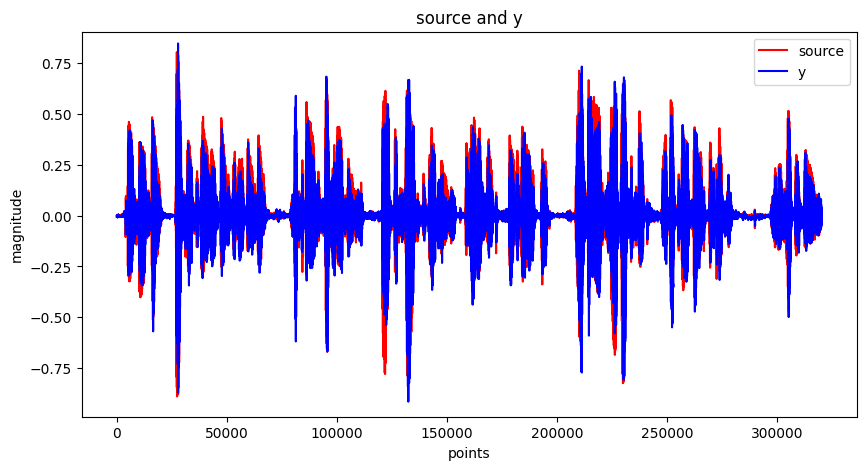

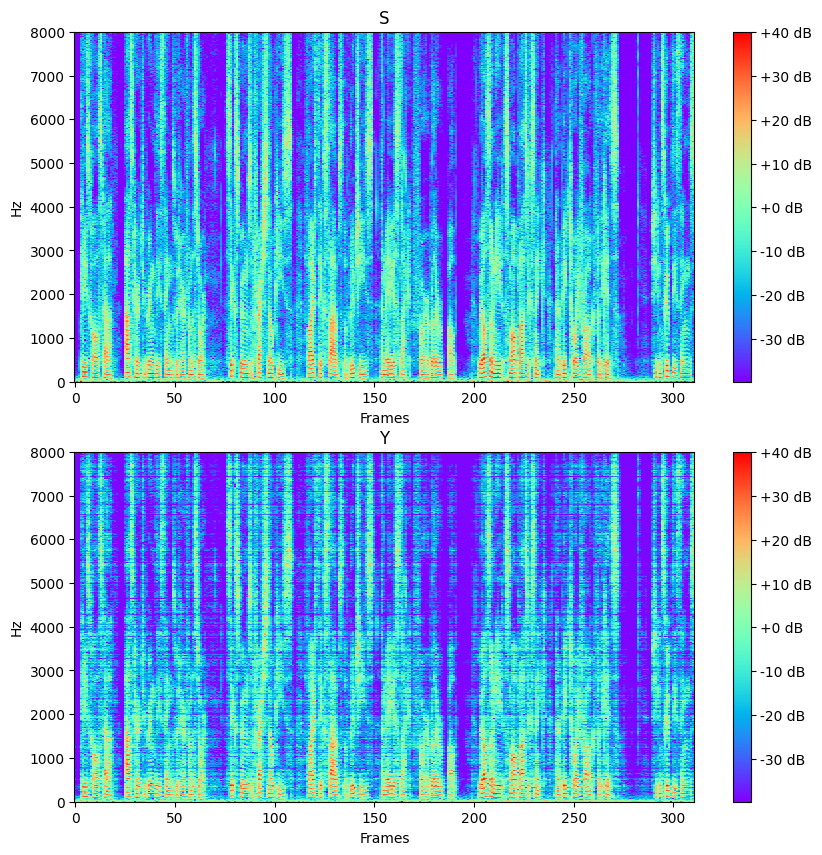

In [39]:
h_conv_source = np.zeros((MicNum, h.shape[1] + source.shape[0] - 1))

for i in range(MicNum) :
    h_conv_source[i, :] = np.convolve(h[i, :], source)

h_conv_source = h_conv_source[:, 0:SorLen] 

# 加上 white noise 當作 interferer #
# SNR = 0
# def awgn(x, SNR, seed=7) :
#     np.random.seed(seed)
#     snr = 10**(SNR/10)
#     x_power = np.sum(x**2)/len(x)
#     noise_power = x_power/snr
#     noise = np.random.randn(len(x))*np.sqrt(noise_power)
    
#     return x + noise

# y = np.zeros((MicNum, SorLen))
# for i in range(MicNum) :
#    y[i, :] =  awgn(h_conv_source[i, :], SNR)

# 不加 white noise #
y = h_conv_source

# 畫 source and mic time plot #
fig5 = plt.figure(figsize=(10, 5))
ax5 = fig5.add_subplot()
ax5.plot(source, 'r')
ax5.plot(y[look_mic], 'b')
source_yaxis_underlimit = np.min(source) - 0.1
source_yaxis_upperlimit = np.max(source) + 0.1
ax5.set_ylim((source_yaxis_underlimit, source_yaxis_upperlimit))
ax5.set_title('source and y')
ax5.set_xlabel('points')
ax5.set_ylabel('magnitude')
ax5.legend(['source', 'y'])
plt.show()

# y 轉頻域 #
Y = librosa.stft(y, n_fft=NFFT, hop_length=hopsize, win_length=NWIN, window='hamming', center=center)

# 畫 source and mic frequency plot #
fig6 = plt.figure(figsize=(10, 10))
ax6_1 = fig6.add_subplot(2, 1, 1)
S_caxis_underlimit = np.min(librosa.amplitude_to_db(np.abs(S)))
S_caxis_upperlimit = np.max(librosa.amplitude_to_db(np.abs(S)))
img = librosa.display.specshow(librosa.amplitude_to_db(np.abs(S)), sr=fs,  hop_length=hopsize, y_axis='linear', x_axis='frames',
                                ax=ax6_1, cmap=cm.rainbow, vmin=S_caxis_underlimit, vmax=S_caxis_upperlimit)
ax6_1.set_title('S')
fig6.colorbar(img, ax=ax6_1, format="%+2.0f dB")

ax6_2 = fig6.add_subplot(2, 1, 2)
img = librosa.display.specshow(librosa.amplitude_to_db(np.abs(Y[look_mic])), sr=fs,  hop_length=hopsize, y_axis='linear', x_axis='frames',
                                ax=ax6_2, cmap=cm.rainbow, vmin=S_caxis_underlimit, vmax=S_caxis_upperlimit)
ax6_2.set_title('Y')
fig6.colorbar(img, ax=ax6_2, format="%+2.0f dB")
plt.show()

## initial Rss Rsy

In [40]:
ini_frame = int(NumOfFrame/10)

# 初始化 Rss #
Rss = np.zeros((L, L, frequency), dtype='complex64')
for FrameNo in range(L-1, ini_frame) :
    S_choose = S[:, FrameNo-L+1:FrameNo+1].T
    for n in range(frequency) :
        Rss[:, :, n] = Rss[:, :, n] + np.dot(np.reshape(np.flip(S_choose[:, n]), (L, 1)), np.reshape(np.conj(np.flip(S_choose[:, n])), (1, L)))

Rss = Rss/(ini_frame-L+1)

# 初始化 Rsy #
Rsy = np.zeros((L, MicNum, frequency), dtype='complex64')
for FrameNo in range(L-1, ini_frame) :
    S_choose = S[:, FrameNo-L+1:FrameNo+1].T
    Y_choose = Y[:, :, FrameNo]
    for n in range(frequency) :
        Rsy[:, :, n] = Rsy[:, :, n] + np.dot(np.reshape(np.flip(S_choose[:, n]), (L, 1)), np.reshape(np.conj(Y_choose[:, n]), (1, MicNum)))
 
Rsy = Rsy/(ini_frame-L+1)

## 畫圖看初始 A 在頻域的樣子 (A_ini)

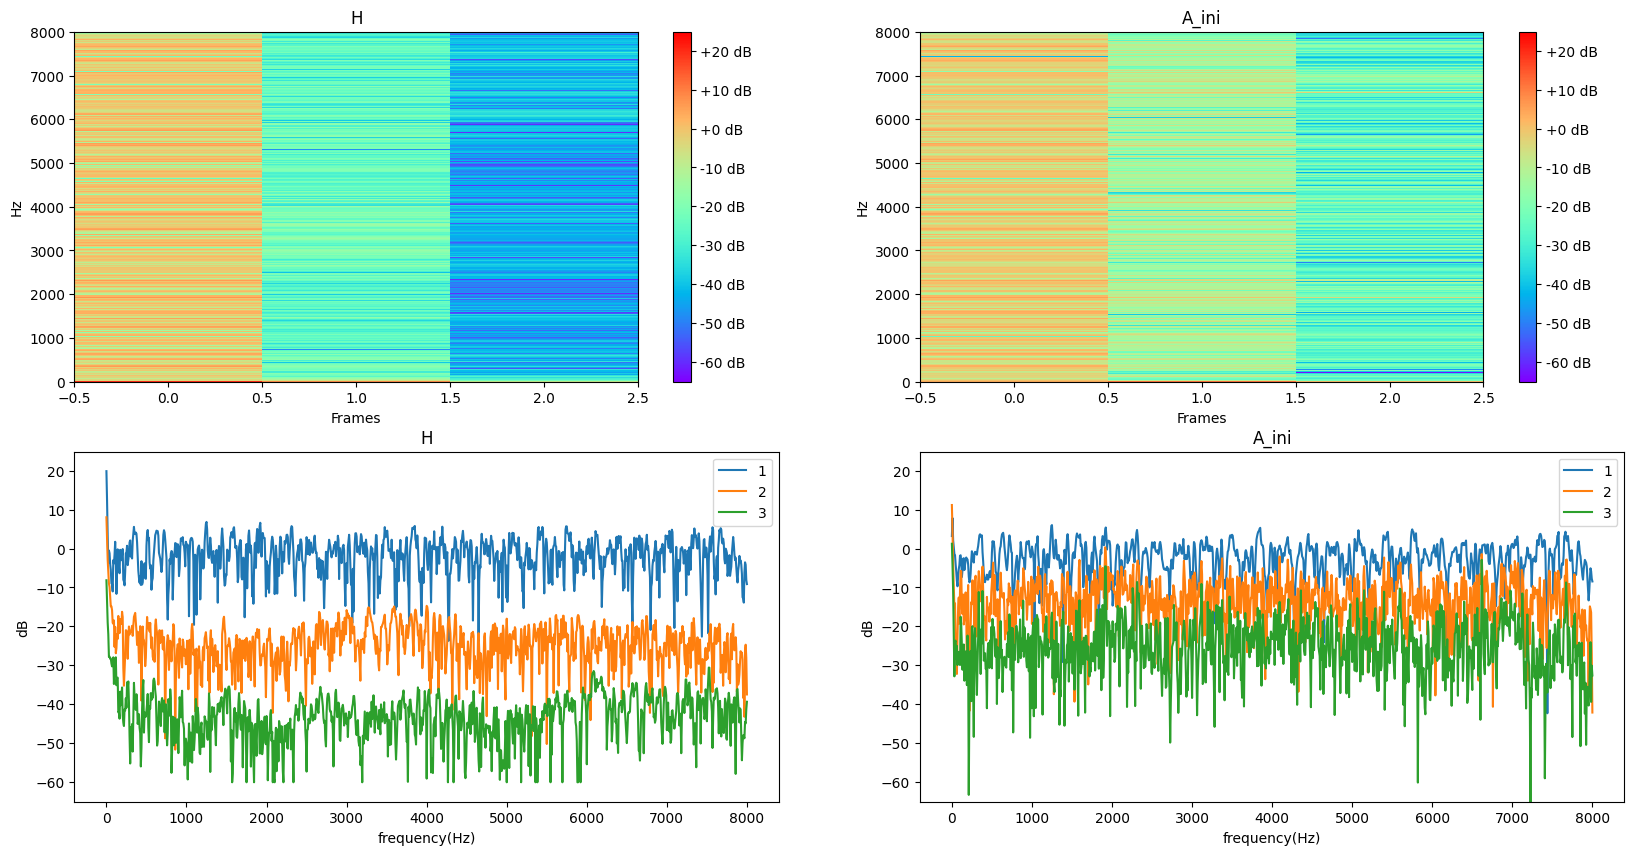

In [41]:
A_ini = np.zeros((MicNum, L, frequency), dtype='complex64')
dia_load_ini = 10**(-4)
for n in range(frequency) :
    A_ini[:, :, n] = np.dot(np.transpose(np.conj(Rsy[:, :, n])), np.linalg.inv(Rss[:,:,n] + dia_load_ini*np.identity(L)))

A_ini_forplot = np.zeros((MicNum, frequency, L), dtype='complex64')
for i in range(A_ini.shape[0]) :
    A_ini_forplot[i, :, :] = np.transpose(A_ini[i, :, :])

# 畫 A_ini frequency plot #
fig7 = plt.figure(figsize=(20, 10))
ax7_1 = fig7.add_subplot(2, 2, 1)
img = librosa.display.specshow(librosa.amplitude_to_db(np.abs(H[look_mic])), sr=fs,  hop_length=hopsize, y_axis='linear', x_axis='frames',
                                ax=ax7_1, cmap=cm.rainbow, vmin=H_caxis_underlimit, vmax=H_caxis_upperlimit)
ax7_1.set_title('H')
fig7.colorbar(img, ax=ax7_1, format="%+2.0f dB")

ax7_2 = fig7.add_subplot(2, 2, 3)
ax7_2.plot(freqs_vector, librosa.amplitude_to_db(np.abs(H[look_mic])))
ax7_2.set_ylim((H_caxis_underlimit, H_caxis_upperlimit))
ax7_2.set_title('H')
ax7_2.set_xlabel('frequency(Hz)')
ax7_2.set_ylabel('dB')
if H[look_mic].shape[1] < 10 :
    ax7_2.legend([str(i+1) for i in range(H[look_mic].shape[1])])

ax7_3 = fig7.add_subplot(2, 2, 2)
img = librosa.display.specshow(librosa.amplitude_to_db(np.abs(A_ini_forplot[look_mic])), sr=fs,  hop_length=hopsize, y_axis='linear', x_axis='frames',
                                ax=ax7_3, cmap=cm.rainbow, vmin=H_caxis_underlimit, vmax=H_caxis_upperlimit)
ax7_3.set_title('A_ini')
fig7.colorbar(img, ax=ax7_3, format="%+2.0f dB")

ax7_4 = fig7.add_subplot(2, 2, 4)
ax7_4.plot(freqs_vector, librosa.amplitude_to_db(np.abs(A_ini_forplot[look_mic])))
ax7_4.set_ylim((H_caxis_underlimit, H_caxis_upperlimit))
ax7_4.set_title('A_ini')
ax7_4.set_xlabel('frequency(Hz)')
ax7_4.set_ylabel('dB')
if H[look_mic].shape[1] < 10 :
    ax7_4.legend([str(i+1) for i in range(H[look_mic].shape[1])])
plt.show()

## 畫圖看初始 A 在時域的樣子 有adjust最高點 (A_ini_tdomain)

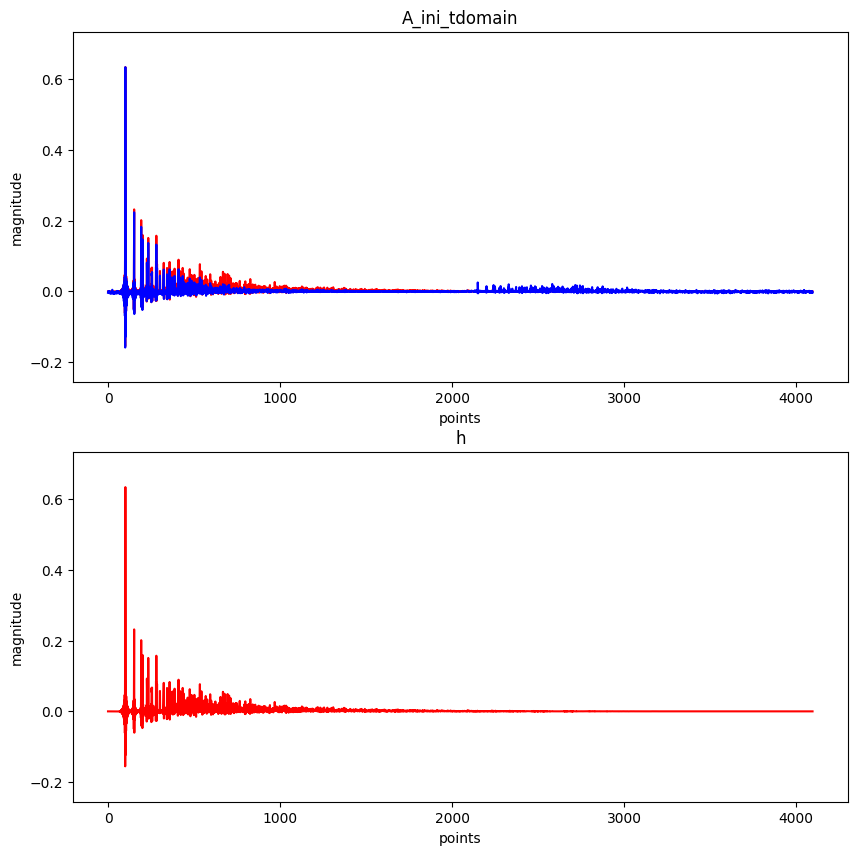

In [42]:
# A_ini 轉回時域 #
A_ini_tdomain = librosa.istft(A_ini_forplot, hop_length=hopsize, win_length=NWIN, n_fft=NFFT, window='boxcar', center=center)

# adjust 使最高點與 h 一樣 #
look_mic = 14    # 在宣告一次 用來看其他mic
h_max = np.max(h[look_mic, :])
A_ini_tdomain_max = np.max(A_ini_tdomain[look_mic, :])
ratio_A_ini_tdomain = h_max/A_ini_tdomain_max

# 畫 A_ini time plot #
h_yaxis_underlimit = np.min(h[look_mic]) - 0.1
h_yaxis_upperlimit = np.max(h[look_mic]) + 0.1

fig8 = plt.figure(figsize=(10, 10))
ax8_1 = fig8.add_subplot(2, 1, 1)
ax8_1.plot(h[look_mic, :], 'r')
ax8_1.plot(A_ini_tdomain[look_mic, :]*ratio_A_ini_tdomain, 'b')
ax8_1.set_ylim((h_yaxis_underlimit, h_yaxis_upperlimit))
ax8_1.set_title('A_ini_tdomain')
ax8_1.set_xlabel('points')
ax8_1.set_ylabel('magnitude')

ax8_2 = fig8.add_subplot(2, 1, 2)
ax8_2.plot(h[look_mic, :], 'r')
ax8_2.set_ylim((h_yaxis_underlimit, h_yaxis_upperlimit))
ax8_2.set_title('h')
ax8_2.set_xlabel('points')
ax8_2.set_ylabel('magnitude')
plt.show()

# 算 h 與 A_ini_tdomain 的 matching error #
single_proof = 10**(-6)
rms = np.sum((h[look_mic, :] - A_ini_tdomain[look_mic, :])**2)/np.sum((h[look_mic, :] + single_proof)**2)

## initial A RAA rAy

In [43]:
A = np.zeros((MicNum, L, frequency), dtype='complex64')

# 用free field point source model 初始化 A #
# freefield_ATF = np.zeros((int(points_rir/2)+1, MicNum), dtype='complex64')
# freefield_ATF_freqs_vector = (fs/2)*np.linspace(0, 1, int(points_rir/2)+1)
# distance = np.zeros((1, MicNum))
# for i in range(MicNum) :
#     distance[:, i] = np.sqrt(np.sum((SorPos - MicPos[:, i])**2))

# for n in range(freefield_ATF_freqs_vector.shape[0]) :
#     omega = 2*np.pi*freefield_ATF_freqs_vector[n]
#     freefield_ATF[n, :] = np.exp(-1j*omega/c*distance) / distance

# freefield_ATF_tdomain = np.fft.irfft(freefield_ATF, axis=0)

# look_mic = 14    # 在宣告一次 用來看其他mic
# fig9 = plt.figure(figsize=(10, 10))
# ax9_1 = fig9.add_subplot(2, 1, 1)
# ax9_1.plot(h[look_mic, :], 'r')
# ax9_1.plot(freefield_ATF_tdomain[:, look_mic], 'b')
# ax9_1.set_title('freefield_ATF_tdomain')
# ax9_1.set_xlabel('points')
# ax9_1.set_ylabel('magnitude')

# ax9_2 = fig9.add_subplot(2, 1, 2)
# ax9_2.plot(h[look_mic, :], 'r')
# ax9_2.set_title('h')
# ax9_2.set_xlabel('points')
# ax9_2.set_ylabel('magnitude')
# plt.show()

# freefield_ATF = librosa.stft(np.transpose(freefield_ATF_tdomain), n_fft=NFFT, hop_length=hopsize, win_length=NWIN, window='boxcar', center=center)

# fig10 = plt.figure(figsize=(10, 10))
# ax10_1 = fig10.add_subplot(2, 1, 1)
# freefield_ATF_caxis_underlimit = np.min(librosa.amplitude_to_db(np.abs(freefield_ATF[look_mic]))) - 5
# freefield_ATF_caxis_upperlimit = np.max(librosa.amplitude_to_db(np.abs(freefield_ATF[look_mic]))) + 5
# img = librosa.display.specshow(librosa.amplitude_to_db(np.abs(H[look_mic])), sr=fs,  hop_length=hopsize, y_axis='linear', x_axis='frames', ax=ax10_1,
#                                 cmap=cm.rainbow, vmin=freefield_ATF_caxis_underlimit, vmax=freefield_ATF_caxis_upperlimit)
# ax10_1.set_title('freefield_ATF')
# fig10.colorbar(img, ax=ax10_1, format="%+2.0f dB")

# ax10_2 = fig10.add_subplot(2, 1, 2)
# ax10_2.plot(freqs_vector, librosa.amplitude_to_db(np.abs(freefield_ATF[look_mic])))
# ax10_2.set_ylim((freefield_ATF_caxis_underlimit, freefield_ATF_caxis_upperlimit))
# ax10_2.set_title('freefield_ATF')
# ax10_2.set_xlabel('frequency(Hz)')
# ax10_2.set_ylabel('dB')
# if freefield_ATF[look_mic].shape[1] < 10 :
#     ax10_2.legend([str(i+1) for i in range(freefield_ATF[look_mic].shape[1])])
# plt.show()

RAA = np.zeros((L, L, frequency), dtype='complex64')
rAy = np.zeros((L, 1, frequency), dtype='complex64')

## recursive process

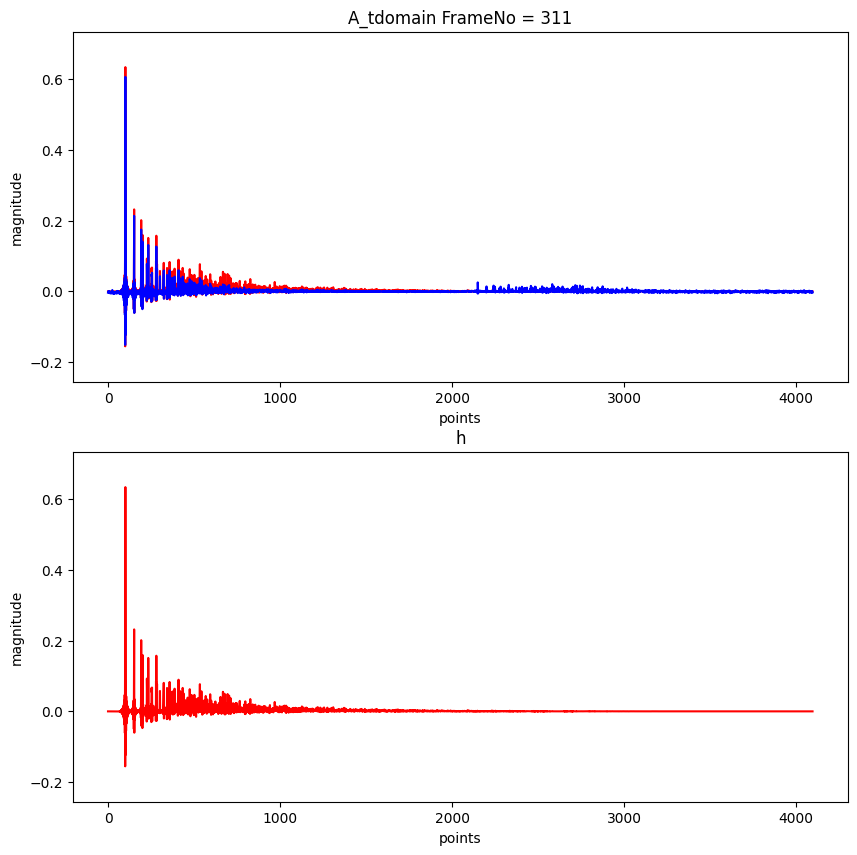

right now processing frame = 311


<Figure size 1000x1000 with 0 Axes>

In [44]:
alpha = 0.99
beta = 0.99
gamma = 0.0001
delta = 0.0001
dia_load_A = 10**(-4)
dia_load_S_predict = 10**(-4)
A_mode = 'predict'    #'predict' or 'true'
save_mode = 'front'    # 'front' or 'back'
S_predict = np.zeros((L, 1, frequency), dtype='complex64')
S_save = np.zeros((frequency, NumOfFrame), dtype='complex64')
S_save_L = np.zeros((frequency, NumOfFrame), dtype='complex64')
A_forplot = np.zeros((MicNum, frequency, L), dtype='complex64')

plt.ion()
fig11 = plt.figure(figsize=(10, 10))

for FrameNo in range(ini_frame, NumOfFrame) :
    for n in range(frequency) :
        Y_before = Y[:, n, FrameNo-1]
        Y_now = Y[:, n, FrameNo]
        # update Rss Rsy using alpha and beta #
        # if FrameNo != ini_frame :
        #     Rss[:, :, n] = alpha*Rss[:, : ,n] + (1 - alpha)*np.dot(S_predict[:, :, n], np.transpose(np.conj(S_predict[:, :, n])))
        #     Rsy[:, :, n] = beta*Rsy[:, :, n] + (1 - beta)*np.dot(S_predict[:, :, n], np.reshape(np.conj(Y_before), (1, MicNum)))

        # update Rss Rsy using frame count based #
        if FrameNo != ini_frame :
            Rss[:, :, n] = ((FrameNo-L)*Rss[:, : ,n] + np.dot(S_predict[:, :, n], np.transpose(np.conj(S_predict[:, :, n]))))/(FrameNo-L+1)
            Rsy[:, :, n] = ((FrameNo-L)*Rsy[:, :, n] + np.dot(S_predict[:, :, n], np.reshape(np.conj(Y_before), (1, MicNum))))/(FrameNo-L+1)

        if A_mode == 'predict' :
            # 使用估到的 S 來更新 A #
            A[:, :, n] = np.dot(np.transpose(np.conj(Rsy[:, :, n])), np.linalg.inv(Rss[:, :, n] + dia_load_A*np.identity(L)))
        else :
            # 使用 ground-truth H 來當作 A #
            for i in range(A.shape[0]) :
                A[i, :, :] = np.transpose(H[i, :, :])

        RAA[:, :, n] = gamma*RAA[:, :, n] + (1 - gamma)*np.dot(np.transpose(np.conj(A[:, :, n])), A[:, :, n])
        rAy[:, :, n] = delta*rAy[:, :, n] + (1 - delta)*np.dot(np.transpose(np.conj(A[:, :, n])), np.reshape(Y_now, (MicNum, 1)))
        S_predict[:, :, n] = np.dot(np.linalg.inv(RAA[:, :, n] + dia_load_S_predict*np.identity(L)), rAy[:, :, n])

    # 儲存 S_predict #
    if save_mode == 'front' :
        # 存最前面的 frame #
        S_save[:, FrameNo] = S_predict[0, :, :]
        S_save_L[:, FrameNo] = S_predict[L-1, :, :]
    else :
        # 存最後面的 frame #
        S_save[:, FrameNo-(L-1)] = S_predict[L-1, :, :]
        if FrameNo == NumOfFrame :
            for count in range(L) :
                S_save[:, NumOfFrame-count] = S_predict[count, :, :]

    # 一直畫 A_tdomain 的變化 #
    if A_mode == 'predict' :
        for i in range(A.shape[0]) :
            A_forplot[i, :, :] = np.transpose(A[i, :, :])

        A_tdomain = librosa.istft(A_forplot, hop_length=hopsize, win_length=NWIN, n_fft=NFFT, window='boxcar', center=center)

        ax11_1 = fig11.add_subplot(2, 1, 1)
        ax11_1.plot(h[look_mic, :], 'r')
        ax11_1.plot(A_tdomain[look_mic, :], 'b')
        ax11_1.set_ylim((h_yaxis_underlimit, h_yaxis_upperlimit))
        ax11_1.set_title('A_tdomain FrameNo = ' + str(FrameNo+1))
        ax11_1.set_xlabel('points')
        ax11_1.set_ylabel('magnitude')

        ax11_2 = fig11.add_subplot(2, 1, 2)
        ax11_2.plot(h[look_mic, :], 'r')
        ax11_2.set_ylim((h_yaxis_underlimit, h_yaxis_upperlimit))
        ax11_2.set_title('h')
        ax11_2.set_xlabel('points')
        ax11_2.set_ylabel('magnitude')
        
        ipd.clear_output(wait=True)
        ipd.display(plt.gcf())
        plt.clf()
        
    # print 出先在處理哪一個 frame #
    print(f'right now processing frame = {FrameNo+1}')

## 畫圖看最後 A 在時域的樣子 有adjust最高點 (A_fin_tdomain)

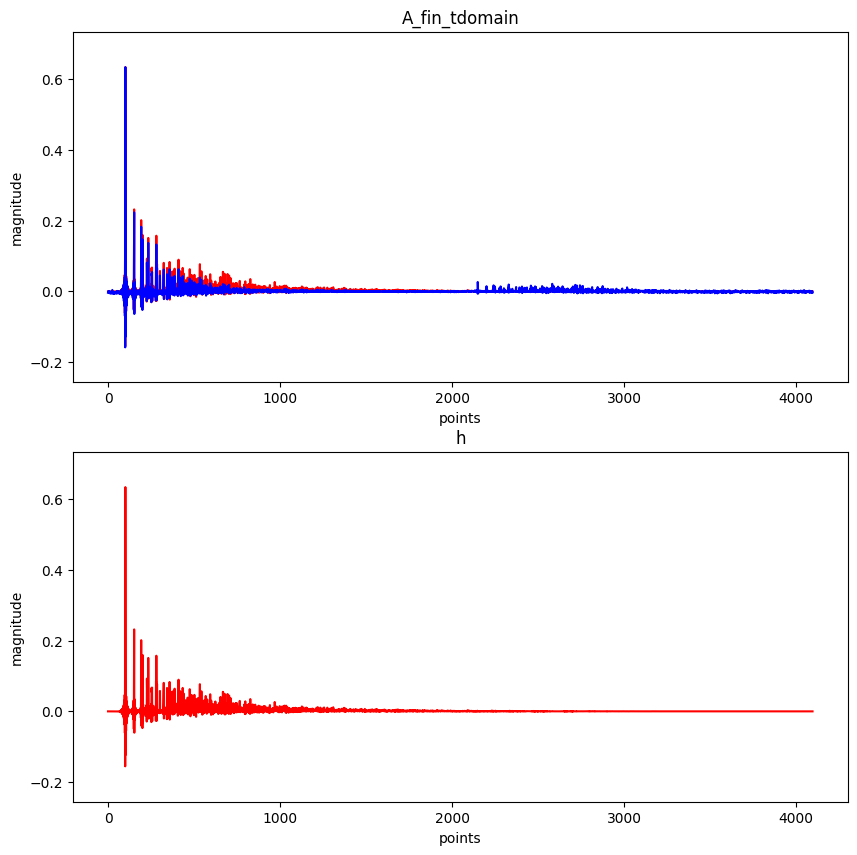

In [45]:
# A_fin 轉回時域 #
A_fin_forplot = np.zeros((MicNum, frequency, L), dtype='complex64')
for i in range(A.shape[0]) :
    A_fin_forplot[i, :, :] = np.transpose(A[i, :, :])

A_fin_tdomain = librosa.istft(A_fin_forplot, hop_length=hopsize, win_length=NWIN, n_fft=NFFT, window='boxcar', center=center)

# adjust 使最高點與 h 一樣 #
look_mic = 14    # 在宣告一次 用來看其他mic
h_max = np.max(h[look_mic, :])
A_fin_tdomain_max = np.max(A_fin_tdomain[look_mic, :])
ratio_A_fin_tdomain = h_max/A_fin_tdomain_max

# 畫 A_fin time plot #
h_yaxis_underlimit = np.min(h[look_mic]) - 0.1
h_yaxis_upperlimit = np.max(h[look_mic]) + 0.1

fig12 = plt.figure(figsize=(10, 10))
ax12_1 = fig12.add_subplot(2, 1, 1)
ax12_1.plot(h[look_mic, :], 'r')
ax12_1.plot(A_fin_tdomain[look_mic, :]*ratio_A_fin_tdomain, 'b')
ax12_1.set_ylim((h_yaxis_underlimit, h_yaxis_upperlimit))
ax12_1.set_title('A_fin_tdomain')
ax12_1.set_xlabel('points')
ax12_1.set_ylabel('magnitude')

ax12_2 = fig12.add_subplot(2, 1, 2)
ax12_2.plot(h[look_mic, :], 'r')
ax12_2.set_ylim((h_yaxis_underlimit, h_yaxis_upperlimit))
ax12_2.set_title('h')
ax12_2.set_xlabel('points')
ax12_2.set_ylabel('magnitude')
plt.show()

## plot spectrogram (S_save S_save_L)

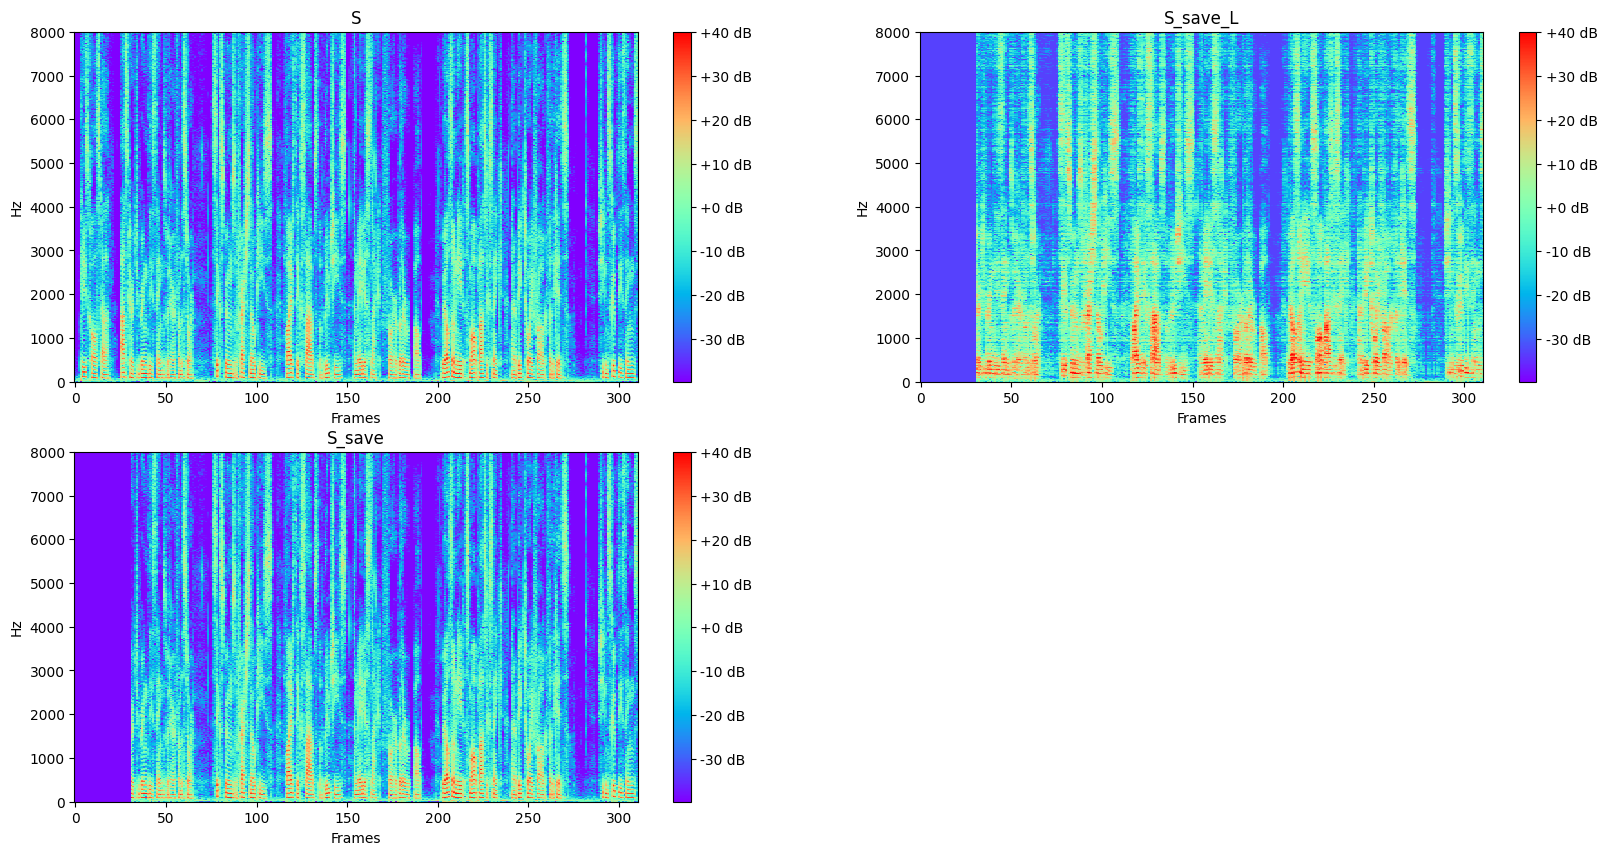

In [46]:
fig13 = plt.figure(figsize=(20, 10))
ax13_1 = fig13.add_subplot(2, 2, 1)
img = librosa.display.specshow(librosa.amplitude_to_db(np.abs(S)), sr=fs,  hop_length=hopsize, y_axis='linear', x_axis='frames',
                                ax=ax13_1, cmap=cm.rainbow, vmin=S_caxis_underlimit, vmax=S_caxis_upperlimit)
ax13_1.set_title('S')
fig13.colorbar(img, ax=ax13_1, format="%+2.0f dB")

ax13_2 = fig13.add_subplot(2, 2, 3)
img = librosa.display.specshow(librosa.amplitude_to_db(np.abs(S_save)), sr=fs,  hop_length=hopsize, y_axis='linear', x_axis='frames',
                                ax=ax13_2, cmap=cm.rainbow, vmin=S_caxis_underlimit, vmax=S_caxis_upperlimit)
ax13_2.set_title('S_save')
fig13.colorbar(img, ax=ax13_2, format="%+2.0f dB")

ax13_3 = fig13.add_subplot(2, 2, 2)
img = librosa.display.specshow(librosa.amplitude_to_db(np.abs(S_save_L)), sr=fs,  hop_length=hopsize, y_axis='linear', x_axis='frames',
                                ax=ax13_3, cmap=cm.rainbow, vmin=S_caxis_underlimit, vmax=S_caxis_upperlimit)
ax13_3.set_title('S_save_L')
fig13.colorbar(img, ax=ax13_3, format="%+2.0f dB")
plt.show()

## predicted source 還原回時域 (source_predict)

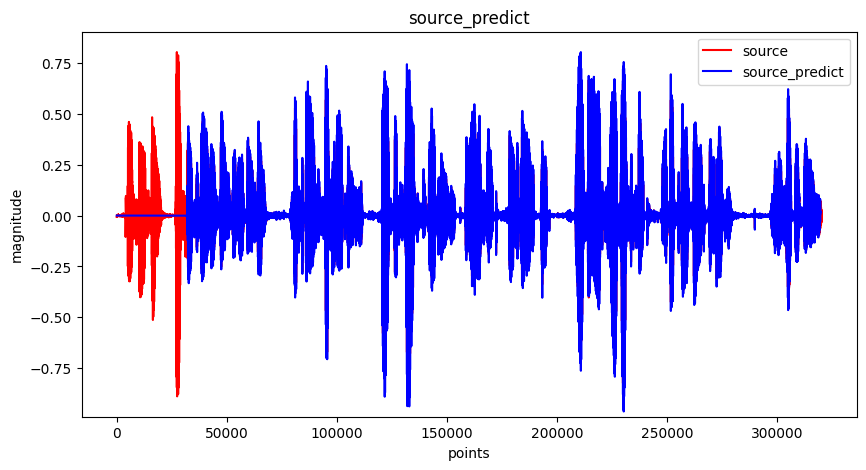

In [47]:
# S_save 轉回時域 #
source_predict = librosa.istft(S_save, hop_length=hopsize, win_length=NWIN, n_fft=NFFT, window='hamming', center=center)

# adjust 使最高點與 source 一樣 #
look_mic = 14    # 在宣告一次 用來看其他mic
source_max = np.max(source)
source_predict_max = np.max(source_predict)
ratio_source_predict = source_max/source_predict_max
source_predict = source_predict*ratio_source_predict

# 畫 source_predict time plot #
fig14 = plt.figure(figsize=(10, 5))
ax14 = fig14.add_subplot()
ax14.plot(source, 'r')
ax14.plot(source_predict, 'b')
ax14.set_ylim((source_yaxis_underlimit, source_yaxis_upperlimit))
ax14.set_title('source_predict')
ax14.set_xlabel('points')
ax14.set_ylabel('magnitude')
ax14.legend(['source', 'source_predict'])
plt.show()

## save .wav 檔

In [48]:
# 直接聽 #
ipd.display(ipd.Audio(source, rate=fs))
ipd.display(ipd.Audio(y[look_mic], rate=fs))
ipd.display(ipd.Audio(source_predict, rate=fs))

# 存 .wav 檔 #
sf.write('py_source.wav', source, fs)
sf.write('py_y.wav', y[look_mic], fs)

source_predict_filemane = 'py_source_predict_NWIN=' + str(NWIN) + '_L=' + str(L) + '_A_mode=' + A_mode + '.wav'
sf.write(source_predict_filemane, source_predict, fs)
print(source_predict_filemane)

# 計時結果 #
time_end = time.time()
time_gap= time_end - time_start
print('total cost = ', time_gap, 'second')

py_source_predict_NWIN=2048_L=3_A_mode=predict.wav
total cost =  149.99404788017273 second
